In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
import argparse

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
import gymnax
import optax
import flax
import pickle
import json

import run
import run_bc


In [11]:
rets = run.run(run.parse_args('--n_iters=500 --save_dir=../data/temp/cartpole --save_agent_params=True'.split()))

Config: Namespace(n_seeds=1, env_id='name=CartPole-v1', agent_id='obs_embed=dense;name=linear_transformer;tl=500', run='train', load_dir=None, save_dir='../data/temp/cartpole', save_buffers=False, save_agent_params=True, ft_first_last_layers=False, n_iters=500, n_envs=4, n_steps=128, n_updates=16, n_envs_batch=1, lr=0.00025, clip_grad_norm=0.5, clip_eps=0.2, vf_coef=0.5, ent_coef=0.01, gamma=0.99, gae_lambda=0.95)


  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
rets_student, rets_teacher = run_bc.run(run_bc.parse_args('--n_seeds=32 --n_iters=100 --load_dir_teacher=../data/temp/cartpole --load_dir=../data/exp_main/train/name=csmdp;d_state=8;d_obs=8;n_acts=4;delta=F;trans=linear;rew=linear;mrl=4x64'.split()))

Config: Namespace(n_seeds=32, env_id='name=CartPole-v1', agent_id='obs_embed=dense;name=linear_transformer;tl=500', run='train', load_dir='../data/exp_main/train/name=csmdp;d_state=8;d_obs=8;n_acts=4;delta=F;trans=linear;rew=linear;mrl=4x64', load_dir_teacher='../data/temp/cartpole', save_dir=None, save_buffers=False, save_agent_params=False, ft_first_last_layers=False, n_iters=100, n_envs=4, n_steps=128, n_updates=16, n_envs_batch=1, lr=0.00025, clip_grad_norm=0.5)


  0%|          | 0/100 [00:00<?, ?it/s]

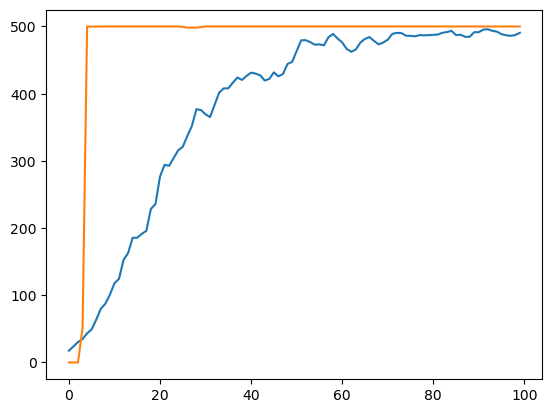

In [13]:
plt.plot(jnp.mean(rets_student, axis=0))
plt.plot(jnp.mean(rets_teacher, axis=0))



In [200]:
env, params = gymnax.make('Freeway-MinAtar')

In [201]:
import jax
from jax.random import split

rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)

obs, state = jax.vmap(env.reset, (0, None))(split(rng, 1024), params)
a = []
for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    act = jax.random.randint(_rng, (1024, ), 0, env.action_space(params).n)
    rng, _rng = split(rng)
    obs, state, rew, done, info = jax.vmap(env.step, (0, 0, 0, None))(split(_rng, 1024), state, act, params)
    a.append(rew)

a = jnp.stack(a).flatten()



  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.hist(np.asarray(a));
plt.yscale('log')

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json



In [ ]:
import matplotlib.colors as mcolors
mcolors.TABLEAU_COLORS


In [ ]:
def viz_training(dir_exp):
    with open(f'{dir_exp}/rets.pkl', 'rb') as f:
        rets = pickle.load(f)
        rets = np.asarray(rets)
    plt.plot(rets[0])


viz_training('../data/exp_main/train/name=csmdp;d_state=8;d_obs=8;n_acts=4;delta=F;trans=linear;rew=linear;mrl=4x64')
viz_training('../data/exp_main/train/name=csmdp;d_state=8;d_obs=8;n_acts=4;delta=F;trans=linear;rew=goal;mrl=4x64')
viz_training('../data/exp_main/train/name=csmdp;d_state=8;d_obs=8;n_acts=4;delta=F;trans=mlp;rew=linear;mrl=4x64')

plt.ylabel('Return')
plt.xlabel('Training Iteration')



In [ ]:
def viz_dir(dir_exp, bar_chart=True):
    # for d in glob.glob(f'{dir_exp}/train/*'):
    #     print(d)
    #     with open(f'{d}/config.json', 'r') as f:
    #         cfg = json.load(f)
    #         print(cfg)
    
    plt.figure(figsize=(12, 8))
    i_plt = 0
    for test_dir in sorted(os.listdir(f'{dir_exp}/test/')):
        i_plt += 1
        plt.subplot(2, 3, i_plt)
        for i, train_dir in enumerate(sorted(os.listdir(f'{dir_exp}/test/{test_dir}/'))):
            with open(f'{dir_exp}/test/{test_dir}/{train_dir}/rets.pkl', 'rb') as f:
                rets = pickle.load(f)
                rets = np.asarray(rets)
                if bar_chart:
                    plt.bar(i, rets[0, -100:].mean(), label=train_dir)
                else:
                    plt.plot(rets[0], label=train_dir)
        plt.title(test_dir)
        
        # print(test_dir)
        # print(rets)
    plt.gcf().supxlabel('Algorithm' if bar_chart else 'Training Iteration')
    plt.gcf().supylabel('End Return' if bar_chart else 'Return')
    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, bbox_to_anchor=(1, 0))
    


viz_dir('../data/exp_main/', bar_chart=True)


In [ ]:
from dataclasses import dataclass

@dataclass
class Dog():
    legs: int
    
@dataclass
class Cat():
    MyDog: object
    def doit(self):
        self.my_dog = self.MyDog()
        print(self.MyDog)
        print(self.my_dog)

from functools import partial
cat = Cat(partial(Dog, legs=4))
cat.doit()
    
    

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from ppo_metagrid import make_train

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:
if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 16*4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 16*5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": True,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1 + 32)
    out = train_fn(jnp.arange(len(_rng)), jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    # rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    # import matplotlib.pyplot as plt
    # 
    # n_iters = rets.shape[1]
    # steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    # plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    # plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    # plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    # plt.legend()
    # plt.ylabel('Return')
    # plt.xlabel('Env Steps')
    # plt.show()
    # 
    # plt.plot(jnp.mean(rets[:, :10, :, :], axis=(0, 1, 3)), label='start of training')
    # plt.plot(jnp.mean(rets[:, -10:, :, :], axis=(0, 1, 3)), label='end of training')
    # plt.legend()
    # plt.xlabel('in context steps')
    # plt.show()
    

In [ ]:
rews = metrics  # seed, iter, step, env
rets = rews.sum(axis=2)  # seed, iter, env
rews.shape, rets.shape

In [ ]:
n_iters = rews.shape[1]
iters = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]

plt.plot(iters, jnp.mean(rets.mean(axis=-1), axis=0), label='mean')
plt.plot(iters, jnp.median(rets.mean(axis=-1), axis=0), label='median')
plt.plot(iters, rets.mean(axis=-1).T, c='gray', alpha=0.1)
plt.legend()
plt.ylabel('Return')
plt.xlabel('Env Steps')
plt.title('MetaGridEnv 64x128, Agent: MetaRLLinearTransformer')
plt.show()


In [ ]:
plt.plot(jnp.mean(rews[:, :10].mean(axis=(1, 3)), axis=0), c=[.5, 0, 0, 1], label='mean start of training')
plt.plot(jnp.mean(rews[:, -10:].mean(axis=(1, 3)), axis=0), c=[0, .5, 0, 1], label='mean end of training')

plt.plot(rews[:, :10].mean(axis=(1, 3)).T, c=[.5, 0, 0, .1])
plt.plot(rews[:, -10:].mean(axis=(1, 3)).T, c=[0, .5, 0, .1])

plt.legend()
plt.ylabel('Per-Step Reward')
plt.xlabel('In-Context Steps')
plt.title('MetaGridEnv 64x128, Agent: MetaRLLinearTransformer')
plt.show()


In [69]:
env.model_done.

NeverDone()

In [3]:
from jax.random import split
from functools import partial

In [4]:
def random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256):
    n_acts = env.action_space(env_params).n
    def step(carry, _):
        rng, state = carry
        rng, _rng = split(rng)
        act = jax.random.randint(_rng, (n_envs,), 0, n_acts)
        rng, _rng = split(rng)
        obs, state_n, rew, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, None))(split(_rng, n_envs), state, act, env_params)
        carry = rng, state_n
        return carry, dict(obs=obs, state=state, act=act, rew=rew, done=done, info=info)
    rng, _rng = split(rng)
    obs, state = jax.vmap(env.reset, in_axes=(0, None))(split(_rng, n_envs), env_params)
    carry = rng, state
    carry, buffer = jax.lax.scan(step, carry, jnp.arange(n_steps))
    buffer = jax.tree_map(lambda x: rearrange(x, 'T N ... -> N T ...'), buffer)
    return buffer


In [15]:

def plot_env(env, env_params):
    state_space = env.state_space(env_params)
    n_acts = env.action_space(env_params).n
    cols = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w'][:n_acts]
    
    lim = jnp.stack([jnp.ones(state_space.shape) * state_space.low, jnp.ones(state_space.shape) * state_space.high])
    xlim, ylim = lim.T

    nlen = 30
    x, y = jnp.linspace(*xlim, nlen), jnp.linspace(*ylim, nlen)
    x, y = jnp.meshgrid(x, y, indexing='ij')
    state_all = rearrange(jnp.stack([x, y], axis=-1), "i j s -> (i j) s")
    act = jnp.arange(n_acts)

    step_fn = partial(env.step, params=env_params)
    step_fn = jax.vmap(jax.vmap(step_fn, in_axes=(None, 0, None)), in_axes=(None, None, 0))
    _rng = jax.random.PRNGKey(0)
    _, state_all_n, _, _, _ = step_fn(_rng, state_all, act)
    
    state, state_n = repeat(state_all, 'ij d -> (a ij) d', a=n_acts), rearrange(state_all_n, 'a ij d -> (a ij) d')
    c = []
    for col in cols:
        c.extend([col] * (nlen * nlen))
    plt.quiver(*state.T, *(state_n-state).T, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)
    
    
    rew_all = jax.vmap(env.get_rew, in_axes=(0, None))(state_all, env_params)
    done_all = jax.vmap(env.is_done, in_axes=(0, None))(state_all, env_params)
    plt.scatter(*state_all.T, c=rew_all, cmap='RdYlGn', alpha=0.3, vmin=rew_all.min(), vmax=rew_all.max(), s=200., label='reward', marker='s', edgecolor='none')
    plt.colorbar()

    # done_all = done_all.at[:100].set(True)
    c = jnp.stack([jnp.zeros_like(done_all), jnp.zeros_like(done_all), jnp.zeros_like(done_all), done_all/2.], axis=-1)
    plt.scatter(*state_all.T, c=c, s=200., label='done', marker='x')#, edgecolor='none')

    buffer = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)
    
    state = rearrange(buffer['state'], 'N T ... -> (N T) ...')  # (N T) D=2
    plt.scatter(*state.T, color=(0,0,1,0.01), label='random walk state distribution')
    state = buffer['state'][:, 0]  # N T D=2
    plt.scatter(*state.T, color=(0,0,0,1.), label='init state distribution')
    
    plt.legend()

env_ids = [
    "name=csmdp;d_state=2;d_obs=8;n_acts=4;delta=T;trans=mlp;rew=linear;mrl=4x64",
    "name=csmdp;d_state=2;d_obs=8;n_acts=4;delta=T;trans=mlp;rew=goal;mrl=4x64",
]
    
for env_id in env_ids:
    env = run.create_env(env_id)
    env = env._env._env._env
    plt.figure(figsize=(12*3, 10*3))
    for i_plt in range(9):
        rng = jax.random.PRNGKey(i_plt)
        env_params = env.sample_params(rng)
        plt.subplot(3, 3, i_plt+1)
        plot_env(env, env_params)
    plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x15e9fbbe0> (for post_execute):


Exception ignored in: <function _xla_gc_callback at 0x1188b0b80>
Traceback (most recent call last):
  File "/Users/akarshkumar0101/miniconda3/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 

KeyboardInterrupt



Error in callback <function flush_figures at 0x2c8cbb400> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# 4*(r**n)/2**n = .1
# 4*(r**n) = .1 * 2**n
# (r**n) = .1 * 2**n / 4
# r = (.1 * 2**n / 4)**(1/n)

In [35]:
env.reset(rng, env_params)

(Array([-2.0289757 , -1.7129874 ,  1.8201582 , -0.9108537 , -2.129796  ,
        -3.021924  ,  0.48640096,  0.03991027], dtype=float32),
 Array([-0.0398829 , -0.65906525], dtype=float32))